# Deconvolution on MNIST


For more technical information on the deconvolution method see: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
from flax.core.frozen_dict import freeze
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-07 08:27:53.711247: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 08:27:55.405365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-07 08:27:55.405858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-07 08:27:55.405872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [35]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        mlp = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,   
        ])
        x = mlp(x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the deconvolutional model
        self.sow("intermediates", "final_conv_layer", x)
        # Flatten for dense layer
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create eh model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ intermedia… ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ _forward_… │ float32[5… │ float32[5… │ final_conv… │            │
│            │            │            │            │ -           │            │
│            │            │            │            │ float32[5,… │            │
│            │            │            │            │             │            │
│            │            │            │            │ 92,160      │            │
│            │            │            │            │ (368.6 KB)  │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ Sequentia… │ Sequential │ float32[5… │ float32[5… │             │            │
├────────────┼────────────┼

### Define the loss function and update method

In [36]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [37]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])

    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [38]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

Iteration:  0
0.11350001
Iteration:  10
0.7275
Iteration:  20
0.78150004
Iteration:  30
0.83150005
Iteration:  40
0.83000004
Iteration:  50
0.85700005
Iteration:  60
0.84800005
Iteration:  70
0.86850005
Iteration:  80
0.8615
Iteration:  90
0.87900007
Iteration:  100
0.87100005
Iteration:  110
0.882
Iteration:  120
0.87750006
Iteration:  130
0.88750005
Iteration:  140
0.882
Iteration:  150
0.89000005
Iteration:  160
0.88500005
Iteration:  170
0.89050007
Iteration:  180
0.88750005
Iteration:  190
0.89100003


### Create the Deconvolutional Model

In [67]:
class _deconvolution(nn.Module):

    @nn.compact
    def __call__(self, x):
        deconv = nn.Sequential([
            nn.ConvTranspose(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,   
            nn.ConvTranspose(features=1, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu, 
        ])

        return deconv(x)

# Create the model object
deconvolution = _deconvolution()

# Display the model details
rng_key = random.PRNGKey(64)
dummy_x = X_val[:5]
initial_params = forward_fn.init(rng_key, dummy_x)
_, state = forward_fn.apply(initial_params, dummy_x, mutable='intermediates')
final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
initial_deconv_params = deconvolution.init(rng_key, final_conv_layer)
print(deconvolution.tabulate(rng_key, final_conv_layer))


                             _deconvolution Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ _deconvoluti… │ float32[24,2… │ float32[28,… │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Sequential_0  │ Sequential    │ float32[24,2… │ float32[28,… │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ ConvTranspos… │ ConvTranspose │ float32[24,2… │ float32[26,… │ kernel:       │
│               │               │               │              │ float32[3,3,… │
│               │               │               │              │               │
│               │               │               │              │ 4,608 (18.4   │
│               │          

### Prepare Deconvolutional Parameters

In [71]:
print(params['params'].keys())
print(params['params']['Conv_0']["kernel"].shape)
print(params['params']['Conv_1']["kernel"].shape)

frozen_dict_keys(['Conv_0', 'Conv_1', 'Dense_0'])
(3, 3, 1, 16)
(3, 3, 16, 32)


In [69]:
print(np.transpose(params['params']['Conv_0']["kernel"], (1, 0, 3, 2)).shape)
print(np.transpose(params['params']['Conv_1']["kernel"], (1, 0, 3, 2)).shape)

(3, 3, 16, 1)
(3, 3, 32, 16)


In [72]:
print(initial_deconv_params['params'].keys())
print(initial_deconv_params['params']['ConvTranspose_0']["kernel"].shape)
print(initial_deconv_params['params']['ConvTranspose_1']["kernel"].shape)

frozen_dict_keys(['ConvTranspose_0', 'ConvTranspose_1'])
(3, 3, 32, 16)
(3, 3, 16, 1)


In [63]:

deconv_params = {
    "params": {
        "ConvTranspose_0": {"kernel": jnp.transpose(params['params']['Conv_1']["kernel"], (1, 0, 3, 2))},
        "ConvTranspose_1": {"kernel": jnp.transpose(params['params']['Conv_0']["kernel"], (1, 0, 3, 2))}
    }
}
# Convert python dict to flax frozen dict
deconv_params = freeze(deconv_params)

### Display predictions and saliency maps


In [64]:
def make_predictions(X, params):
    logits, state = forward_fn.apply(params, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction, state = make_predictions(X_val[None, index], params)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]

    attributions = deconvolution.apply(deconv_params, final_conv_layer)

    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)

    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

Prediction:  [1]
Label:  1


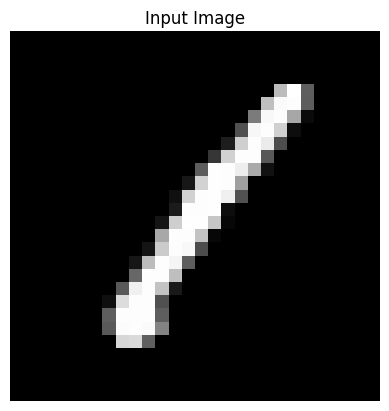

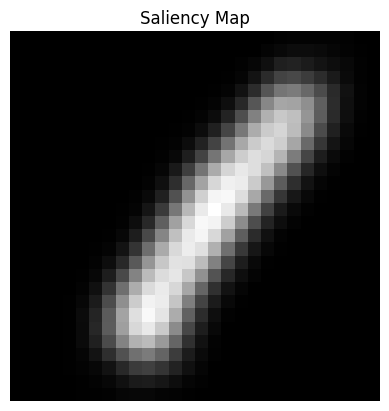

Prediction:  [2]
Label:  4


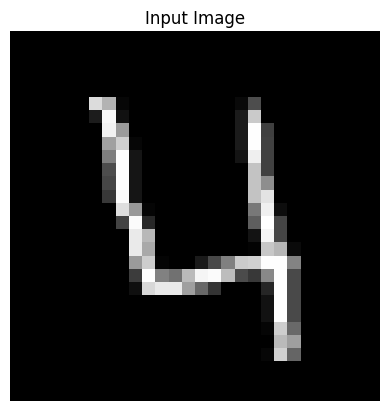

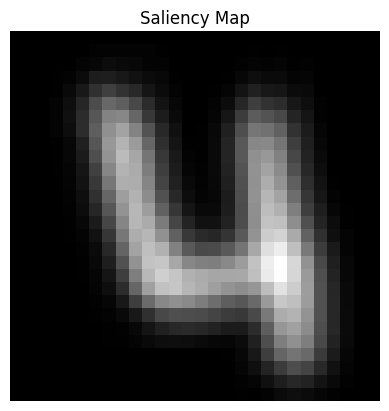

Prediction:  [0]
Label:  0


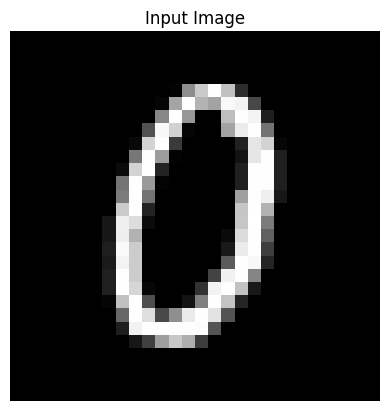

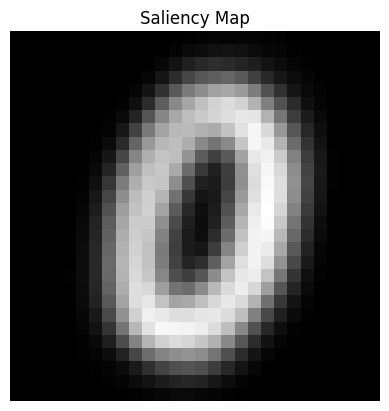

Prediction:  [5]
Label:  5


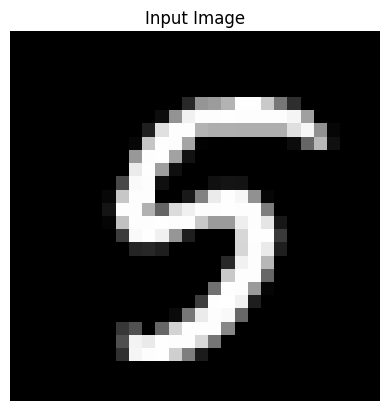

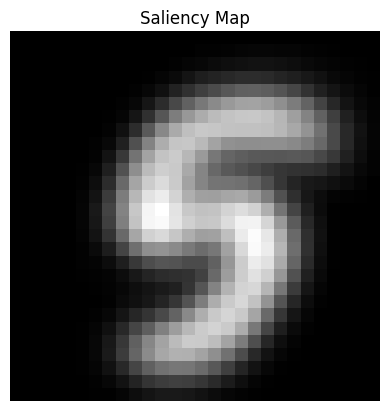

Prediction:  [8]
Label:  8


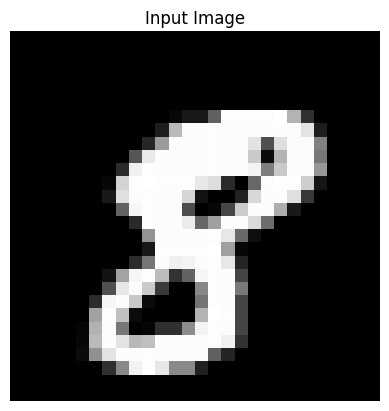

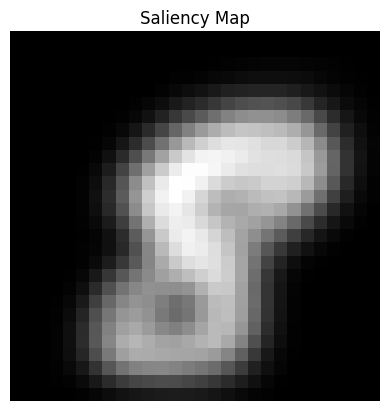

Prediction:  [7]
Label:  7


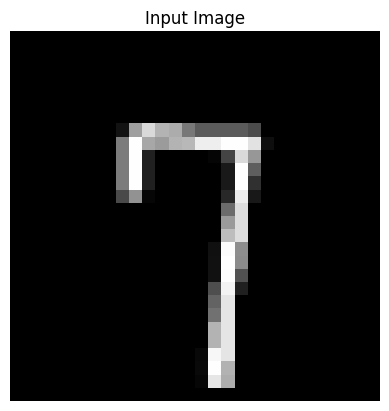

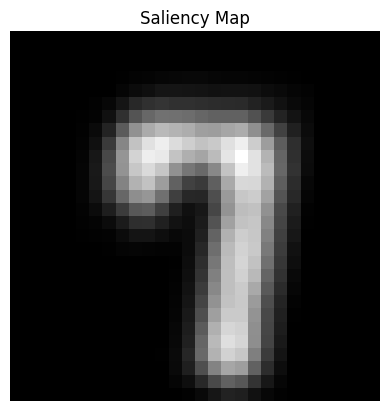

In [65]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)